In [ ]:
# Read and subset the chat messages
dota2_pbatch_df = pd.read_csv('dota_pbatch_df.csv')
dota_chatframe = dota2_pbatch_df.loc[dota2_pbatch_df['type'] == "chat"]
dota_chatframe

In [ ]:
dota2_df = pd.read_csv('dota_df.csv')
dota_chats = dota2_df.loc[dota2_df['type'] == "chat"]
dota_chats

In [47]:
dota_combined_df = pd.read_csv('combined_df.csv')
dota_combined_df_chats = dota_combined_df.loc[dota_combined_df['type'] == "chat"]
dota_combined_df_chats

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,time,type,key,slot,player_slot,id,avg_mmr,unit
51,51,51,51,807,chat,GANEN SU WEBADA,9,132,6629454411,3012,NaN
52,52,52,52,820,chat,GRACIAS,9,132,6629454411,3012,NaN
53,53,53,53,920,chat,TREMNENDA COMPRA CUENTAS MI AM,7,130,6629454411,3012,NaN
54,54,54,54,924,chat,1K DE MRD SIN ITEMS,7,130,6629454411,3012,NaN
67,67,67,67,1263,chat,xdd,0,0,6629454411,3012,NaN
...,...,...,...,...,...,...,...,...,...,...,...
64038,36948,859,11,1709,chat,gg,0,0,6944091304,3477,NaN
64039,36949,860,12,1714,chat,GG,0,0,6944091304,3477,NaN
64040,36950,861,13,1718,chat,GG,2,2,6944091304,3477,NaN
64041,36951,862,14,1721,chat,gg,2,2,6944091304,3477,NaN


In [2]:
import pandas as pd

## Read Kaggle frames

In [82]:
kaggle_chats = pd.read_csv('chat.csv')
kaggle_match = pd.read_csv('match.csv')
kaggle_player_ratings = pd.read_csv('player_ratings.csv')
kaggle_players = pd.read_csv('players.csv')

In [78]:
#https://github.com/odota/core/wiki/MMR-Data

# Read the txt file. Each acc
kaggle_mmr = pd.read_csv('mmr.txt', sep='\s+', header=None)
kaggle_mmr = pd.concat([kaggle_mmr[1][::2].reset_index(drop=True), kaggle_mmr[1][1::2].reset_index(drop=True)], axis=1)
kaggle_mmr.columns = ['account_id', 'mmr']

1069672

Number of unique account_ids in the ratings dataframe: 833263
Number of unique account_ids in the players dataframe 158360
Player_ratings dataframe:
        match_id  account_id  trueskill_mu
0              0           1     26.232905
1           9035           1     26.232905
2              0           2     27.614505
3          10667           2     27.614505
4          42504           2     27.614505
...          ...         ...           ...
286294     49998      158355     23.054222
286295     49998      158356     26.880745
286296     49998      158357     21.537147
286297     49998      158358     23.059192
286298     49999      158359     22.449502

[286299 rows x 3 columns]


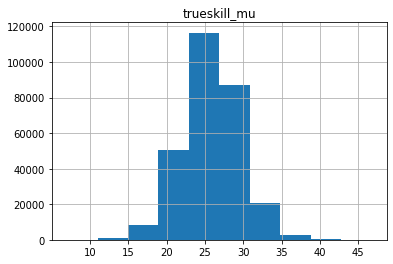

In [127]:
## testa matcha ratings med players bara
players_column = kaggle_players[['match_id', 'account_id']]
players_column = players_column[players_column.account_id != 0] # Remove rows for players with hidden profiles == no account information: https://www.kaggle.com/datasets/devinanzelmo/dota-2-matches?datasetId=273&sortBy=voteCount&select=player_ratings.csv

ratings_columns = kaggle_player_ratings[['account_id', 'trueskill_mu']]
ratings_columns = ratings_columns[ratings_columns.account_id != 0]

(ratings_columns < 0).any() ## Is true for account_id, but account_id shouldn't be negative. Convert to abs
ratings_columns['account_id'] = ratings_columns['account_id'].abs()

print("Number of unique account_ids in the ratings dataframe:", len(set(ratings_columns['account_id'])))
print("Number of unique account_ids in the players dataframe", len(set(players_column['account_id'])))


players_ratings = pd.merge(players_column, ratings_columns, on="account_id")
players_ratings.hist(column='trueskill_mu')
print("Player_ratings dataframe:")
print(players_ratings)


Shared dataframe (s2)
      match_id  account_id  trueskill_mu   mmr
0           19         111     21.925789  3730
1           60         343     26.544163  4235
2           60         343     27.332469  4235
3          206        1217     26.521103  5001
4          206        1217     26.008137  5001
...        ...         ...           ...   ...
2009     49930      158217     22.879511  3483
2010     49930      158217     29.767782  3483
2011     49988      158341     24.440123  3157
2012     49988      158341     21.376367  3157
2013     49991      158344     28.174150  3069

[2014 rows x 4 columns]
Joined dataframe (s1):
        match_id  account_id  trueskill_mu  mmr
0              0           1     26.232905  NaN
1           9035           1     26.232905  NaN
2              0           2     27.614505  NaN
3          10667           2     27.614505  NaN
4          42504           2     27.614505  NaN
...          ...         ...           ...  ...
286294     49998      158355  

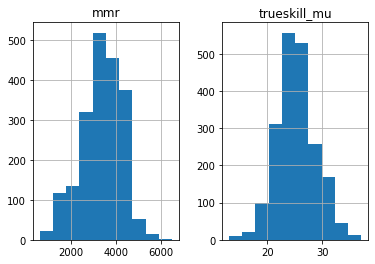

In [192]:
## combine players_ratings with kaggle_mmr (left join)
s1 = pd.merge(players_ratings, kaggle_mmr, how='left', on=['account_id'])
## Base mmr estimation for the missing values on the inner join dataframe
s2 = pd.merge(players_ratings, kaggle_mmr, how='inner', on=['account_id'])

s2.hist(column=["mmr", "trueskill_mu"]) # Can see that it roughly resembles the distribution of trueskill_mu, so we will approximate 3000~ mmr as 25~
print("Shared dataframe (s2)")
print(s2)

print("Joined dataframe (s1):")
print(s1)

# Need to deal with the missing/NaN values
# https://trueskill.org/
# https://www.kaggle.com/code/devinanzelmo/dota-2-skill-rating-with-trueskill?scriptVersionId=0

In [193]:
# trueskill
trueskill_mean = s2['trueskill_mu'].mean()
trueskill_var = s2['trueskill_mu'].var()
trueskill_min = s2['trueskill_mu'].min()
trueskill_max = s2['trueskill_mu'].max()

print("The variance of recorded trueskill: ", trueskill_var)
print("The mean of recorded trueskill: ", trueskill_mean)
print("The min of recorded trueskill: ", trueskill_min)
print("The max of recorded trueskill: ", trueskill_max)

# mmr
mmr_mean = s2['mmr'].mean()
mmr_var = s2['mmr'].var()
mmr_min = s2['mmr'].min()
mmr_max = s2['mmr'].max()

print("The variance of recorded mmr: ", mmr_var)
print("The mean of recorded mmr: ", mmr_mean)
print("The min of recorded mmr: ", mmr_min)
print("The max of recorded mmr: ", mmr_max)


The variance of recorded trueskill:  12.54514487059052
The mean of recorded trueskill:  25.272255788826243
The min of recorded trueskill:  13.043780259290974
The max of recorded trueskill:  37.085464920482366
The variance of recorded mmr:  796094.9694937228
The mean of recorded mmr:  3397.6941410129098
The min of recorded mmr:  631
The max of recorded mmr:  6507


In [190]:
import numpy as np
# Bins in percentages
herald = [0, 9.73] 
guardian = [9.73, 26.48]
crusader = [26.48, 48.58]
archon = [48.58, 70.79]
legend = [70.79, 86.62]
ancient = [86.62, 95.04]
divine_immortal = [95.04, 100]

# range 
skill_range_trueskill = trueskill_max - trueskill_min
skill_range_mmr = mmr_max - mmr_min
# create custom bin size equal to 1% 
binwidth_base_trueskill = skill_range_trueskill/100
binwidth_base_mmr = skill_range_mmr/100

# Bins equal to the percentage of player ranks
bins = [herald, guardian, crusader, archon, legend, ancient, divine_immortal]
bin_decimals = sorted(set(np.asarray(bins).flatten()))# {0.0, 9.73, 26.48, 48.58, 70.79, 86.62, 95.04, 100.0}

# Translate ranges to custom bins
trueskill_bin_range = []
for i in bin_decimals:
    lim = trueskill_min + i*binwidth_base_trueskill
    trueskill_bin_range.append(lim)

mmr_bin_range = []
for i in bin_decimals:
    lim = mmr_min + i*binwidth_base_mmr
    mmr_bin_range.append(lim)

print("Trueskill ranges:", trueskill_bin_range)
print("MMR ranges:", mmr_bin_range)

Trueskill ranges: [13.043780259290974, 15.383036176824897, 19.410018357574454, 24.72323066769775, 30.06288883094836, 33.86868751281496, 35.89299736128727, 37.085464920482366]
MMR ranges: [631.0, 1202.7348, 2186.9647999999997, 3485.5607999999997, 4790.6204, 5720.7912, 6215.5504, 6507.0]


In [210]:
# approximate average mmr in the ranges:

for i in range(1, len(mmr_bin_range)):      
    rows = s2.loc[(s2['trueskill_mu'] >= trueskill_bin_range[i-1]) & (s2['trueskill_mu'] < trueskill_bin_range[i])]
    print(rows)
    print(rows['trueskill_mu'])
    
    


      match_id  account_id  trueskill_mu   mmr
297       1456        7484     13.821314  2469
376       2318       11720     13.631374  2262
378      11084       11720     13.631374  2262
380      11394       11720     13.631374  2262
382      36702       11720     13.631374  2262
384      45930       11720     13.631374  2262
920       7389       34956     14.304917  4284
922      28641       34956     14.304917  4284
1354     17234       70187     13.043780  2207
297     13.821314
376     13.631374
378     13.631374
380     13.631374
382     13.631374
384     13.631374
920     14.304917
922     14.304917
1354    13.043780
Name: trueskill_mu, dtype: float64
      match_id  account_id  trueskill_mu   mmr
118        776        4176     17.953898  3625
119       1716        4176     17.953898  3625
120       5349        4176     17.953898  3625
121      35566        4176     17.953898  3625
308       1617        8231     19.013748  4382
...        ...         ...           ...   ...
1817

In [167]:
# Data originates from 2015: https://academictorrents.com/details/5c5deeb6cfe1c944044367d2e7465fd8bd2f4acf





skill_range

24.04168466119139

In [100]:
kaggle_mmr['account_id'] = kaggle_mmr['account_id'].abs()
kaggle_mmr

,account_id,mmr
0,103757918,1
1,107361667,1
2,108464725,1
3,110818765,1
4,111436016,1
...,...,...
1069667,173727526,8470
1069668,149486894,8560
1069669,26316691,8575
1069670,91735466,8645


In [101]:
id_mmr = pd.merge(match_account, kaggle_mmr, on="account_id")
id_mmr

,match_id,account_id,mmr
0,19,111,3730
1,60,343,4235
2,206,1217,5001
3,335,1952,4483
4,369,2160,2634
...,...,...,...
1518,49324,156999,3597
1519,49619,157587,3734
1520,49930,158217,3483
1521,49988,158341,3157


In [71]:
kaggle_match

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,1824,0,0,63,117,22,True,0,0,111
49996,49996,1447829181,1451,1982,384,48,63,147,22,True,0,0,204
49997,49997,1447829197,2672,1830,0,0,63,130,22,True,0,0,111
49998,49998,1447829189,2211,1982,4,3,63,645,22,True,0,0,151


In [74]:
list(set(kaggle_players['match_id']))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [42]:
kaggle_players = pd.merge(kaggle_players, kaggle_mmr, on='account_id', how='left') # add mmr to players


In [46]:
kaggle_players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,mmr_x,mmr_y,mmr
0,0,0,86,0,3261,10960,347,362,9,3,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,...,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499996,49999,0,9,129,3755,20815,507,607,12,6,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499997,49999,0,90,130,1059,16225,371,404,5,3,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499998,49999,0,73,131,3165,31015,780,703,8,6,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
kaggle_match

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,1824,0,0,63,117,22,True,0,0,111
49996,49996,1447829181,1451,1982,384,48,63,147,22,True,0,0,204
49997,49997,1447829197,2672,1830,0,0,63,130,22,True,0,0,111
49998,49998,1447829189,2211,1982,4,3,63,645,22,True,0,0,151


For each match_id in ``kaggle_match`` I want to obtain the average mmr of the players in that game. Bind kaggle_mmr to kaggle_players. Then for each match_id in kaggle_match, calculate the avg_mmr of players in that game.

In [29]:
kaggle_chats

,match_id,key,slot,time,unit
0,0,force it,6,-8,6k Slayer
1,0,space created,1,5,Monkey
2,0,hah,1,6,Monkey
3,0,ez 500,6,9,6k Slayer
4,0,mvp ulti,4,934,Kira
...,...,...,...,...,...
1439483,49999,ez,8,2796,DamN.Pussy_Jr
1439484,49999,ya ya so ezx,1,2796,StopDancing
1439485,49999,ez,8,2797,DamN.Pussy_Jr
1439486,49999,hahaha,1,2798,StopDancing


## Analysis

- Data set statistics
    - Histogram avg mmr
    - Region histogram
    - 

- Preprocess



1. VADER

2. 